import urllib.request

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")

In [104]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [11]:
df = all_data

In [12]:
# Need to change columns to row-index 0
#df.rename(columns = df.loc[0], inplace =True)

# Remove row 0
#df = df.drop([0], inplace=True)

#Drop dups
df.drop_duplicates(inplace=True)


In [14]:
# Need to convert EXITS column field11 into numeric type
df['EXITS'] = df['EXITS'].astype(np.float64)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684040 entries, 1 to 2684040
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   C/A       object 
 1   UNIT      object 
 2   SCP       object 
 3   STATION   object 
 4   LINENAME  object 
 5   DIVISION  object 
 6   DATE      object 
 7   TIME      object 
 8   DESC      object 
 9   ENTRIES   object 
 10  EXITS     float64
dtypes: float64(1), object(10)
memory usage: 245.7+ MB


In [16]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,0007035249,2384833.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,0007035269,2384840.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,0007035292,2384875.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,0007035392,2384951.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,0007035651,2385020.0


In [44]:
# Need to find the max(EXITS) for each (SCP) by DATE
#This excludes the EXITS count from TIME 20:00-23:59 each day. The data from this date frame is not as relevant to my company of interest.
#The EXITS count during this time is likely minimal. Additionally, scooters are reclaimed at night to charge to be redeployed the next morning.
#I used previous EXITS with .shift method initially. However, for C/A==S101A, SCP==01-00-03 between 05/01/2019 and 05/02/2019 there was an unexplained jump from 432 to 1078346838.
max_exit = df.groupby(['C/A','SCP','DATE'])[['EXITS']].max()

In [45]:
# Need to find the min(EXITS) for each (SCP) by DATE
min_exit = df.groupby(['C/A','SCP','DATE'])[['EXITS']].min()

In [90]:
#Merging total scp exits data into one df, on matching SCP column
total_scp_exit = pd.merge(max_exit, min_exit, on=['C/A','SCP','DATE'])
total_scp_exit.head()

EXITS_x    EXITS_y
C/A  SCP      DATE                            
A002 02-00-00 04/27/2019  2385070.0  2384833.0
              04/28/2019  2385240.0  2385087.0
              04/29/2019  2385732.0  2385256.0
              04/30/2019  2386197.0  2385765.0
              05/01/2019  2386673.0  2386229.0

In [91]:
# total_scp_exits = max-min for each turnstile SCP per DATE
total_scp_exit['exits_per_day'] = total_scp_exit['EXITS_x']-total_scp_exit['EXITS_y']
total_scp_exit.head()

EXITS_x    EXITS_y  exits_per_day
C/A  SCP      DATE                                           
A002 02-00-00 04/27/2019  2385070.0  2384833.0          237.0
              04/28/2019  2385240.0  2385087.0          153.0
              04/29/2019  2385732.0  2385256.0          476.0
              04/30/2019  2386197.0  2385765.0          432.0
              05/01/2019  2386673.0  2386229.0          444.0

In [100]:
total_scp_exit.loc['N207','00-00-00'].sort_values(by=['exits_per_day'],ascending=False).round(2)

,EXITS_x,EXITS_y,exits_per_day
DATE,,,
06/14/2019,1.828766e+09,7.175686e+06,1.821591e+09
07/12/2019,1.828801e+09,1.828799e+09,2.297000e+03
07/09/2019,1.828795e+09,1.828794e+09,1.720000e+03
07/10/2019,1.828798e+09,1.828796e+09,1.456000e+03
07/18/2019,1.828810e+09,1.828809e+09,1.397000e+03
...,...,...,...
07/04/2019,1.828790e+09,1.828789e+09,6.660000e+02
05/05/2019,7.129813e+06,7.129181e+06,6.320000e+02
05/12/2019,7.137651e+06,7.137034e+06,6.170000e+02


In [93]:
#Find avg EXITS per day per SCP.
avg_daily_exit = total_scp_exit.groupby(['C/A','SCP'])[['exits_per_day']].mean()
avg_daily_exit.head()

exits_per_day
C/A  SCP                    
A002 02-00-00     346.791209
     02-00-01     203.901099
     02-03-00    1485.406593
     02-03-01    1522.923077
     02-03-02    1157.890110

C:\Users\andro\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='exits_per_day', ylabel='Density'>

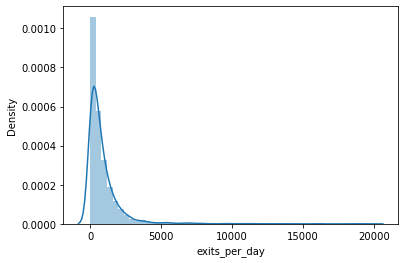

In [106]:
sns.distplot(avg_daily_exit[(avg_daily_exit.exits_per_day <20000)].exits_per_day)

In [95]:
avg_daily_exit.loc['N207'].round(2)

,exits_per_day
SCP,
00-00-00,20018448.09
00-00-01,470.93
00-00-02,349.04
00-00-03,456.09


In [67]:
#Group by C/A and return the mean of daily exits of all SCP per C/A
station_daily = avg_daily_exit.groupby(['C/A'])[['exits_per_day']].mean()
station_daily.head(10)

,exits_per_day
C/A,
A002,523.565934
A006,871.822802
A007,530.265690
A010,768.451923
A011,2987.151648
A013,894.094017
A015,702.142857
A016,455.487912
A021,2150.969780


In [103]:
station_daily = station_daily.sort_values(by=['exits_per_day'],ascending=False).round(decimals=2)
station_daily.head(40)

,exits_per_day
C/A,
N207,5004931.04
R311,4432364.54
R401,3887735.07
R287,2219960.60
R258,2034608.14
R288,1974849.12
R257,1618902.76
N559,1505898.63
C008,1446025.49


In [ ]:
# Group by (C/A) combine SUM(total_scp_exits) for each (C/A) = total_station_exits


In [ ]:
#I could also produce another metric for total avg exits for the past 4 weeks, updated 

In [ ]:
#Calculate metric for busiest day 